In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

In [ ]:
# import data into dataframe
df_raw = pd.read_csv('raw_data.zip', compression = 'zip').drop(columns=['Unnamed: 0'])
df_feature = pd.read_csv('feature_data.zip', compression = 'zip').drop(columns=['Unnamed: 0'])
df_labels = pd.read_csv('label_data.zip', compression = 'zip').drop(columns=['Unnamed: 0'])

In [ ]:
df_raw.head()

,id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_000644bb2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,id_0015fd391,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,id_001626bd3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_feature.head()

,id,with_drug,time,dosage,drug,g-0,g-1,g-2,g-3,g-4,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,True,24,D1,b68db1d53,1.0620,0.5577,-0.2479,-0.6208,-0.1944,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,True,72,D1,df89a8e5a,0.0743,0.4087,0.2991,0.0604,1.0190,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,id_000a6266a,True,48,D1,18bb41b2c,0.6280,0.5817,1.5540,-0.0764,-0.0323,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,id_0015fd391,True,48,D1,8c7f86626,-0.5138,-0.2491,-0.2656,0.5288,4.0620,...,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,id_001626bd3,True,72,D2,7cbed3131,-0.3254,-0.4009,0.9700,0.6919,1.4180,...,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125


## IGNORE ABOVE

In [1]:
! pip install autogluon

In [2]:
import sys
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
import torch.nn as nn
import pandas as pd
import torch.nn.functional as F
from torch.autograd import Variable
import torch.utils.data as Data

from tensorflow import keras

from torch.optim import Adam, SGD
from sklearn.metrics import confusion_matrix
from keras.layers import Dense, Bidirectional, Conv1D, MaxPool1D, Flatten, Dropout
from keras.layers import Input
from keras.models import Model
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import BatchNormalization
import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.metrics import ConfusionMatrixDisplay, precision_recall_fscore_support
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Add

In [3]:
from autogluon.tabular import TabularDataset, TabularPredictor
from sklearn.model_selection import StratifiedShuffleSplit
from tensorflow.keras.layers import SimpleRNN, LSTM

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [6]:
from pathlib import Path

DATA = Path("/gdrive/My Drive/columbia_masters/classes/2021_f/genomics/genomics_project")

In [7]:
# read data
df_raw = pd.read_csv(DATA / 'raw_data.zip', compression = 'zip').drop(columns=['Unnamed: 0'])
df_feature = pd.read_csv(DATA / 'feature_data.zip', compression = 'zip').drop(columns=['Unnamed: 0'])
df_labels = pd.read_csv(DATA / 'label_data.zip', compression = 'zip').drop(columns=['Unnamed: 0'])

In [8]:
# save features and labels in a variable
df_raw = pd.merge(df_feature, df_labels, on='id')
df_raw.head()

,id,with_drug,time,dosage,drug,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,g-10,g-11,g-12,g-13,g-14,g-15,g-16,g-17,g-18,g-19,g-20,g-21,g-22,g-23,g-24,g-25,g-26,g-27,g-28,g-29,g-30,g-31,g-32,g-33,g-34,...,protein_synthesis_inhibitor,protein_tyrosine_kinase_inhibitor,radiopaque_medium,raf_inhibitor,ras_gtpase_inhibitor,retinoid_receptor_agonist,retinoid_receptor_antagonist,rho_associated_kinase_inhibitor,ribonucleoside_reductase_inhibitor,rna_polymerase_inhibitor,serotonin_receptor_agonist,serotonin_receptor_antagonist,serotonin_reuptake_inhibitor,sigma_receptor_agonist,sigma_receptor_antagonist,smoothened_receptor_antagonist,sodium_channel_inhibitor,sphingosine_receptor_agonist,src_inhibitor,steroid,syk_inhibitor,tachykinin_antagonist,tgf-beta_receptor_inhibitor,thrombin_inhibitor,thymidylate_synthase_inhibitor,tlr_agonist,tlr_antagonist,tnf_inhibitor,topoisomerase_inhibitor,transient_receptor_potential_channel_antagonist,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_000644bb2,True,24,D1,b68db1d53,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,-1.0220,-0.0326,0.5548,-0.0921,1.1830,0.1530,0.5574,-0.4015,0.1789,-0.6528,-0.7969,0.6342,0.1778,-0.3694,-0.5688,-1.1360,-1.1880,0.6940,0.4393,0.2664,0.1907,0.1628,-0.2853,0.5819,0.2934,-0.5584,-0.0916,-0.3010,-0.1537,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,True,72,D1,df89a8e5a,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,0.2341,0.3372,-0.4047,0.8507,-1.1520,-0.4201,-0.0958,0.4590,0.0803,0.2250,0.5293,0.2839,-0.3494,0.2883,0.9449,-0.1646,-0.2657,-0.3372,0.3135,-0.4316,0.4773,0.2075,-0.4216,-0.1161,-0.0499,-0.2627,0.9959,-0.2483,0.2655,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,True,48,D1,18bb41b2c,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,0.1715,0.2155,0.0065,1.2300,-0.4797,-0.5631,-0.0366,-1.8300,0.6057,-0.3278,0.6042,-0.3075,-0.1147,-0.0570,-0.0799,-0.8181,-1.5320,0.2307,0.4901,0.4780,-1.3970,4.6240,-0.0437,1.2870,-1.8530,0.6069,0.4290,0.1783,0.0018,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,id_0015fd391,True,48,D1,8c7f86626,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,-1.9590,0.1792,-0.1321,-1.0600,-0.8269,-0.3584,-0.8511,-0.5844,-2.5690,0.8183,-0.0532,-0.8554,0.1160,-2.3520,2.1200,-1.1580,-0.7191,-0.8004,-1.4670,-0.0107,-0.8995,0.2406,-0.2479,-1.0890,-0.7575,0.0881,-2.7370,0.8745,0.5787,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,id_001626bd3,True,72,D2,7cbed3131,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,-0.2800,-0.1498,-0.8789,0.8630,-0.2219,-0.5121,-0.9577,1.1750,0.2042,0.1970,0.1244,-1.7090,-0.3543,-0.5160,-0.3330,-0.2685,0.7649,0.2057,1.3720,0.6835,0.8056,-0.3754,-1.2090,0.2965,-0.0712,0.6389,0.6674,-0.0783,1.1740,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [9]:
df_labels.head()

,id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,adrenergic_receptor_agonist,adrenergic_receptor_antagonist,akt_inhibitor,aldehyde_dehydrogenase_inhibitor,alk_inhibitor,ampk_activator,analgesic,androgen_receptor_agonist,androgen_receptor_antagonist,anesthetic_-_local,angiogenesis_inhibitor,angiotensin_receptor_antagonist,anti-inflammatory,antiarrhythmic,antibiotic,anticonvulsant,antifungal,antihistamine,antimalarial,antioxidant,antiprotozoal,antiviral,apoptosis_stimulant,aromatase_inhibitor,atm_kinase_inhibitor,atp-sensitive_potassium_channel_antagonist,atp_synthase_inhibitor,atpase_inhibitor,atr_kinase_inhibitor,aurora_kinase_inhibitor,...,protein_synthesis_inhibitor,protein_tyrosine_kinase_inhibitor,radiopaque_medium,raf_inhibitor,ras_gtpase_inhibitor,retinoid_receptor_agonist,retinoid_receptor_antagonist,rho_associated_kinase_inhibitor,ribonucleoside_reductase_inhibitor,rna_polymerase_inhibitor,serotonin_receptor_agonist,serotonin_receptor_antagonist,serotonin_reuptake_inhibitor,sigma_receptor_agonist,sigma_receptor_antagonist,smoothened_receptor_antagonist,sodium_channel_inhibitor,sphingosine_receptor_agonist,src_inhibitor,steroid,syk_inhibitor,tachykinin_antagonist,tgf-beta_receptor_inhibitor,thrombin_inhibitor,thymidylate_synthase_inhibitor,tlr_agonist,tlr_antagonist,tnf_inhibitor,topoisomerase_inhibitor,transient_receptor_potential_channel_antagonist,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_000644bb2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,id_0015fd391,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,id_001626bd3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [10]:
df_feature.head()

,id,with_drug,time,dosage,drug,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,g-10,g-11,g-12,g-13,g-14,g-15,g-16,g-17,g-18,g-19,g-20,g-21,g-22,g-23,g-24,g-25,g-26,g-27,g-28,g-29,g-30,g-31,g-32,g-33,g-34,...,c-60,c-61,c-62,c-63,c-64,c-65,c-66,c-67,c-68,c-69,c-70,c-71,c-72,c-73,c-74,c-75,c-76,c-77,c-78,c-79,c-80,c-81,c-82,c-83,c-84,c-85,c-86,c-87,c-88,c-89,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,True,24,D1,b68db1d53,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,-1.0220,-0.0326,0.5548,-0.0921,1.1830,0.1530,0.5574,-0.4015,0.1789,-0.6528,-0.7969,0.6342,0.1778,-0.3694,-0.5688,-1.1360,-1.1880,0.6940,0.4393,0.2664,0.1907,0.1628,-0.2853,0.5819,0.2934,-0.5584,-0.0916,-0.3010,-0.1537,...,0.4805,0.4965,0.3680,0.8427,0.1042,0.1403,0.1758,1.2570,-0.5979,1.2250,-0.0553,0.7351,0.5810,0.9590,0.2427,0.0495,0.4141,0.8432,0.6162,-0.7318,1.2120,0.6362,-0.4427,0.1288,1.4840,0.1799,0.5367,-0.1111,-1.0120,0.6685,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,True,72,D1,df89a8e5a,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,0.2341,0.3372,-0.4047,0.8507,-1.1520,-0.4201,-0.0958,0.4590,0.0803,0.2250,0.5293,0.2839,-0.3494,0.2883,0.9449,-0.1646,-0.2657,-0.3372,0.3135,-0.4316,0.4773,0.2075,-0.4216,-0.1161,-0.0499,-0.2627,0.9959,-0.2483,0.2655,...,0.4083,0.0319,0.3905,0.7099,0.2912,0.4151,-0.2840,-0.3104,-0.6373,0.2887,-0.0765,0.2539,0.4443,0.5932,0.2031,0.7639,0.5499,-0.3322,-0.0977,0.4329,-0.2782,0.7827,0.5934,0.3402,0.1499,0.4420,0.9366,0.8193,-0.4236,0.3192,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,id_000a6266a,True,48,D1,18bb41b2c,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,0.1715,0.2155,0.0065,1.2300,-0.4797,-0.5631,-0.0366,-1.8300,0.6057,-0.3278,0.6042,-0.3075,-0.1147,-0.0570,-0.0799,-0.8181,-1.5320,0.2307,0.4901,0.4780,-1.3970,4.6240,-0.0437,1.2870,-1.8530,0.6069,0.4290,0.1783,0.0018,...,-0.5477,-0.7576,-0.0444,0.1894,-0.0014,-2.3640,-0.4682,0.1210,-0.5177,-0.0604,0.1682,-0.4436,0.4963,0.1363,0.3335,0.9760,-0.0427,-0.1235,0.0959,0.0690,-0.9416,-0.7548,-0.1109,-0.6272,0.3019,0.1172,0.1093,-0.3113,0.3019,-0.0873,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,id_0015fd391,True,48,D1,8c7f86626,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,-1.9590,0.1792,-0.1321,-1.0600,-0.8269,-0.3584,-0.8511,-0.5844,-2.5690,0.8183,-0.0532,-0.8554,0.1160,-2.3520,2.1200,-1.1580,-0.7191,-0.8004,-1.4670,-0.0107,-0.8995,0.2406,-0.2479,-1.0890,-0.7575,0.0881,-2.7370,0.8745,0.5787,...,-2.1220,-0.3752,-2.3820,-3.7350,-2.9740,-1.4930,-1.6600,-3.1660,0.2816,-0.2990,-1.1870,-0.5044,-1.7750,-1.6120,-0.9215,-1.0810,-3.0520,-3.4470,-2.7740,-1.8460,-0.5568,-3.3960,-2.9510,-1.1550,-3.2620,-1.5390,-2.4600,-0.9417,-1.5550,0.2431,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,id_001626bd3,True,72,D2,7cbed3131,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,-0.2800,-0.1498,-0.8789,0.8630,-0.2219,-0.5121,-0.9577,1.1750,0.2042,0.1970,0.1244,-1.7090,-0.3543,-0.5160,-0.3330,-0.2685,0.7649,0.2057,1.3720,0.6835,0.8056,-0.3754,-1.2090,0.2965,-0.0712,0.6389,0.6674,-0.0783,1.1740,...,-0.2274,0.3215,0.1535,-0.4640,-0.5943,0.3973,0.1500,0.5178,0.5159,0.6091,0.1813,-0.4249,0.7832,0.6529,0.5648,0.4817,0.0587,0.5303,0.6376,-0.3966,-1.4950,-0.9625,-0.0541,0.6273,0.4563,0.0698,0.8134,0.1924,0.6054,-0.1824,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125


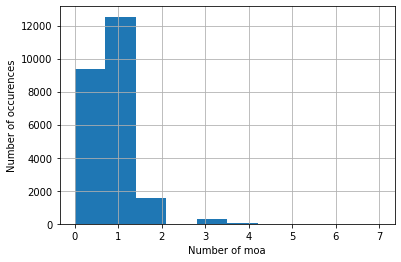

In [11]:
df_raw['n_moa'] = df_labels.drop('id', axis=1).sum(axis=1)
plt.hist(df_raw['n_moa'])
plt.title = 'Number of occurences by number of moa'
plt.xlabel('Number of moa')
plt.ylabel('Number of occurences')

plt.grid(True)
plt.show()

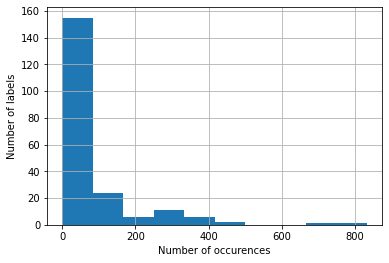

In [12]:
labels_count = df_labels.drop(columns='id').sum(axis=0)
plt.hist(labels_count)
plt.xlabel('Number of occurences')
plt.ylabel('Number of labels')
plt.title = 'Number of labels by number of occurences'
plt.grid(True)
plt.show()

In [13]:
# check how many occurences of each label
np.unique(labels_count, return_counts=True)

(array([  1,   6,   7,  12,  13,  17,  18,  19,  23,  24,  25,  26,  29,
         30,  31,  32,  35,  36,  37,  38,  39,  42,  43,  44,  47,  48,
         49,  50,  51,  54,  55,  56,  59,  60,  61,  62,  66,  67,  68,
         71,  72,  73,  74,  80,  84,  85,  89,  92,  93,  96,  97,  98,
        102, 103, 104, 106, 115, 119, 121, 127, 130, 151, 158, 165, 170,
        190, 192, 223, 236, 241, 264, 266, 267, 270, 273, 279, 281, 283,
        297, 301, 316, 336, 340, 360, 367, 402, 404, 424, 435, 726, 832]),
 array([ 2, 16,  4, 11,  2,  1, 13,  4,  2,  5,  8,  3,  1,  6,  4,  1,  1,
        12,  6,  1,  1,  4,  1,  1,  1,  7,  1,  1,  1,  3,  2,  2,  1,  3,
         3,  2,  1,  2,  1,  1,  3,  5,  2,  2,  1,  1,  2,  1,  1,  3,  1,
         1,  1,  1,  1,  2,  2,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1]))

Remove columns (labels) with less than 15 occurences

In [14]:
labels_count = df_labels.drop(columns='id').sum(axis=0)
# minimum label occurences
min_label_occur = 100
# we need to add one because we need to count the id column
drop_labels = list(labels_count[(labels_count<min_label_occur)].index)
drop_labels

['5-alpha_reductase_inhibitor',
 '11-beta-hsd1_inhibitor',
 'acat_inhibitor',
 'acetylcholinesterase_inhibitor',
 'adenosine_receptor_agonist',
 'adenosine_receptor_antagonist',
 'adenylyl_cyclase_activator',
 'akt_inhibitor',
 'aldehyde_dehydrogenase_inhibitor',
 'alk_inhibitor',
 'ampk_activator',
 'analgesic',
 'androgen_receptor_agonist',
 'androgen_receptor_antagonist',
 'anesthetic_-_local',
 'angiogenesis_inhibitor',
 'angiotensin_receptor_antagonist',
 'anti-inflammatory',
 'antiarrhythmic',
 'antibiotic',
 'anticonvulsant',
 'antifungal',
 'antihistamine',
 'antimalarial',
 'antioxidant',
 'antiprotozoal',
 'antiviral',
 'apoptosis_stimulant',
 'aromatase_inhibitor',
 'atm_kinase_inhibitor',
 'atp-sensitive_potassium_channel_antagonist',
 'atp_synthase_inhibitor',
 'atpase_inhibitor',
 'atr_kinase_inhibitor',
 'aurora_kinase_inhibitor',
 'autotaxin_inhibitor',
 'bacterial_30s_ribosomal_subunit_inhibitor',
 'bacterial_50s_ribosomal_subunit_inhibitor',
 'bacterial_antifolate',
 

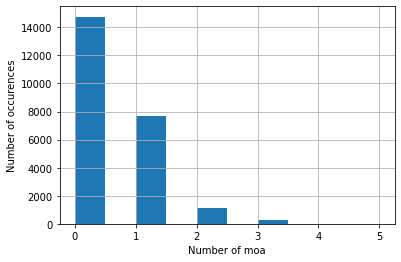

In [15]:
# drop on dataset
sel_raw = df_raw.drop(columns=drop_labels)
sel_labels = df_labels.drop(columns=drop_labels)

# re-calculate n_moa
sel_raw['n_moa'] = sel_labels.drop('id', axis=1).sum(axis=1)
plt.hist(sel_raw['n_moa'])
plt.title = 'Number of occurences by number of moa'
plt.xlabel('Number of moa')
plt.ylabel('Number of occurences')

plt.grid(True)
plt.show()

Remove rows (samples) with:
* `n_moa > 1`
* `n_moa!= 1`

In [16]:
# keep only rows with one or less moa
zon_moa_idx = np.where(sel_raw['n_moa']>1)[0]
zon_moa_feature = df_feature.drop(index=zon_moa_idx).reset_index(drop=True)
zon_moa_labels = sel_labels.drop(index=zon_moa_idx).reset_index(drop=True)
# keep only rows with one moa
one_moa_idx = np.where(sel_raw['n_moa']!=1)[0]
one_moa_feature = df_feature.drop(index=one_moa_idx).reset_index(drop=True)
one_moa_labels = sel_labels.drop(index=one_moa_idx).reset_index(drop=True)

In [17]:
print(f'All n moa shapes {(df_feature.shape, df_labels.shape)}')
print(f'One or less moa only shapes {(zon_moa_feature.shape, zon_moa_labels.shape)}')
print(f'One moa only shapes {(one_moa_feature.shape, one_moa_labels.shape)}')

All n moa shapes ((23814, 877), (23814, 207))
One or less moa only shapes ((22449, 877), (22449, 42))
One moa only shapes ((7694, 877), (7694, 42))


Separate Training and testing (and validation) data

In [18]:
# get train set
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
print(sss)
one_moa_feature['dtype'] = 'test'
one_moa_labels['dtype'] = 'test'
for train_index, test_index in sss.split(one_moa_feature.drop(columns=['id']), one_moa_labels.drop(columns=['id'])):
  one_moa_feature.iloc[train_index, -1] = 'train'
  one_moa_labels.iloc[train_index, -1] = 'train'
  one_moa_feature.iloc[test_index, -1] = 'test'
  one_moa_labels.iloc[test_index, -1] = 'test'

# get test and validation sets
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.7, random_state=42)
print(sss)
for val_index, test_index in sss.split(one_moa_feature.drop(columns=['id'])[one_moa_feature['dtype'] == 'test'], one_moa_labels.drop(columns=['id'])[one_moa_labels['dtype'] == 'test']):
  one_moa_feature.iloc[val_index, -1] = 'val'
  one_moa_labels.iloc[val_index, -1] = 'val'
  one_moa_feature.iloc[test_index, -1] = 'test'
  one_moa_labels.iloc[test_index, -1] = 'test'

StratifiedShuffleSplit(n_splits=1, random_state=42, test_size=0.3,
            train_size=None)
StratifiedShuffleSplit(n_splits=1, random_state=42, test_size=0.7,
            train_size=None)


In [19]:
one_moa_labels['dtype'].value_counts()

train    3758
test     3244
val       692
Name: dtype, dtype: int64

In [20]:
train_labels = one_moa_labels[one_moa_labels.iloc[:, -1] == 'train'].drop(columns=['id', 'dtype']).to_numpy()
train_labels = np.argmax(train_labels, axis=1)
# train_labels = keras.utils.to_categorical(
#     train_labels, dtype='int32'
# )
# train_labels = np.reshape(train_labels, (train_labels.shape[0], train_labels.shape[1], 1)).astype('float')

test_labels = one_moa_labels[one_moa_labels.iloc[:, -1] == 'test'].drop(columns=['id', 'dtype']).to_numpy()
test_labels = np.argmax(test_labels, axis=1)
# test_labels = keras.utils.to_categorical(
#     test_labels, dtype='int32'
# )
# test_labels = np.reshape(test_labels, (test_labels.shape[0], test_labels.shape[1], 1)).astype('float')

val_labels = one_moa_labels[one_moa_labels.iloc[:, -1] == 'val'].drop(columns=['id', 'dtype']).to_numpy()
val_labels = np.argmax(val_labels, axis=1)
# val_labels = keras.utils.to_categorical(
#     val_labels, dtype='int32'
# )
# val_labels = np.reshape(val_labels, (val_labels.shape[0], val_labels.shape[1], 1)).astype('float')

# np.expand_dims(train_features[:,:-1], axis = 2)

train_features = one_moa_feature[one_moa_feature.iloc[:, -1] == 'train'].drop(columns=['id', 'dtype']).reset_index(drop=True)
temp = pd.get_dummies(train_features)
drug_cols = [col for col in temp.columns if col.startswith('drug_')]
drug_int = (temp[drug_cols].idxmax(axis=0))-min(temp[drug_cols].idxmax(axis=0))
train_features['drug'] = drug_int.reset_index(drop=True).astype(int)
train_features['with_drug'] = train_features['with_drug'].astype(int)
train_features.loc[np.where(train_features.dosage=='D1')[0],'dosage']=0
train_features.loc[np.where(train_features.dosage=='D2')[0],'dosage']=1
# train_features = np.expand_dims(train_features.to_numpy(), axis = 2)

test_features = one_moa_feature[one_moa_feature.iloc[:, -1] == 'test'].drop(columns=['id', 'dtype']).reset_index(drop=True)
temp = pd.get_dummies(test_features)
drug_cols = [col for col in temp.columns if col.startswith('drug_')]
drug_int = (temp[drug_cols].idxmax(axis=0))-min(temp[drug_cols].idxmax(axis=0))
test_features['drug'] = drug_int.reset_index(drop=True).astype(int)
test_features.loc[np.where(test_features.dosage=='D1')[0], 'dosage']=0
test_features.loc[np.where(test_features.dosage=='D2')[0], 'dosage']=1
test_features['with_drug'] = test_features['with_drug'].astype(int)
# test_features = np.expand_dims(test_features.to_numpy(), axis = 2)

val_features = one_moa_feature[one_moa_feature.iloc[:, -1] == 'val'].drop(columns=['id', 'dtype']).reset_index(drop=True)
temp = pd.get_dummies(val_features)
drug_cols = [col for col in temp.columns if col.startswith('drug_')]
drug_int = (temp[drug_cols].idxmax(axis=0))-min(temp[drug_cols].idxmax(axis=0))
val_features['drug'] = drug_int.reset_index(drop=True).astype(int)
val_features.loc[np.where(val_features.dosage=='D1')[0], 'dosage']=0
val_features.loc[np.where(val_features.dosage=='D2')[0], 'dosage']=1
val_features['with_drug'] = val_features['with_drug'].astype(int)
# val_features = np.expand_dims(val_features.to_numpy(), axis = 2)

In [263]:
# train_features = one_moa_feature[one_moa_feature.iloc[:, -1] == 'train'].drop(columns=['id', 'dtype']).reset_index(drop=True)
# temp = pd.get_dummies(train_features)
# drug_cols = [col for col in temp.columns if col.startswith('drug_')]
# drug_col = (temp[drug_cols].idxmax(axis=0))-min(temp[drug_cols].idxmax(axis=0))
# train_features['drug'] = drug_col.reset_index(drop=True).astype(int)
# train_features.head()

,with_drug,time,dosage,drug,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,g-10,g-11,g-12,g-13,g-14,g-15,g-16,g-17,g-18,g-19,g-20,g-21,g-22,g-23,g-24,g-25,g-26,g-27,g-28,g-29,g-30,g-31,g-32,g-33,g-34,g-35,...,c-60,c-61,c-62,c-63,c-64,c-65,c-66,c-67,c-68,c-69,c-70,c-71,c-72,c-73,c-74,c-75,c-76,c-77,c-78,c-79,c-80,c-81,c-82,c-83,c-84,c-85,c-86,c-87,c-88,c-89,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,True,24,D2,181.0,0.4658,1.4250,-0.5632,-0.0119,0.6751,-0.7467,-0.1810,0.6779,0.5926,1.3180,0.0152,-0.2709,0.2239,-0.0124,0.3578,0.0158,-0.6066,0.0202,0.0000,-0.2948,-0.5171,0.4444,0.5350,0.2812,1.1870,-0.2028,0.2292,-0.3417,0.3714,-0.9600,-0.0175,-0.8604,0.4275,-0.4485,-1.6020,0.5405,...,-0.1225,-0.3381,0.4055,-0.3498,0.1593,0.2194,-0.0765,-1.6440,-0.5519,0.2824,0.2647,-0.0433,0.5480,0.4726,-0.7551,0.4549,-0.6002,-0.1714,-0.0009,-0.2587,0.8485,-0.1661,-0.2362,-0.0050,-0.8434,0.6395,0.9370,-0.9632,0.2297,-0.8573,0.0575,-0.5601,-0.2339,-0.2814,0.2419,0.7509,0.5843,-0.7467,-0.1309,-0.1908
1,True,24,D1,274.0,-0.5043,0.1211,-0.5380,-0.3511,-0.0050,-0.0128,-0.4338,0.9652,-0.3734,0.6840,-0.1578,-0.6227,-0.6514,-1.4570,0.2358,0.3081,-0.0632,0.1040,-0.1019,0.5123,0.5274,-0.2736,0.2426,0.4924,0.1726,-0.6227,-0.1724,-0.0331,0.8268,-0.2341,-0.4472,-0.5801,0.4156,-0.6220,0.9109,0.1679,...,-0.0482,0.6582,-0.7727,-0.1590,1.6530,0.0026,-1.7780,-0.4627,-1.0200,0.8589,-0.2143,0.7226,0.5150,1.0900,-0.5075,-0.1194,-0.8222,1.3570,-1.4610,0.6811,0.0402,-1.1650,-0.4445,1.5550,-0.2412,0.2904,-0.7027,-0.6599,0.4470,0.8200,-0.1949,0.0248,0.7269,-0.7356,0.0433,0.9164,-0.8046,-0.6839,0.3994,-1.4120
2,True,72,D2,715.0,1.1830,-0.6798,-0.2405,-1.6620,-0.1134,0.4659,0.0334,0.0078,0.3076,1.1850,-0.4538,-0.0871,-1.4850,0.0621,-0.5607,0.6849,0.4531,0.3387,-0.3851,0.0585,0.3828,0.0106,-0.5473,0.4757,0.2059,-0.7943,-1.6040,0.6475,0.8998,1.0530,-1.4710,0.1649,0.1244,0.0705,-1.5500,-0.4618,...,-0.2990,-1.4240,-1.1740,-0.7987,-2.2690,-2.0650,-1.4460,-0.8470,-0.9399,-0.9628,0.4444,-3.7130,-0.3087,0.3414,-0.3110,-2.9850,-1.2670,-0.9795,-0.9623,-1.0720,-0.6720,-1.6730,-2.7360,-1.0110,-1.0510,-2.9010,0.0849,-0.0971,-0.9119,-0.6381,-0.3363,-1.0470,-1.3730,-2.0460,-1.5470,0.5246,-0.6099,-1.0640,-0.5936,-1.2520
3,True,48,D2,88.0,1.2070,1.4360,3.1000,-1.6010,0.4305,-0.5074,-0.5459,0.5481,-0.6325,0.8063,0.0197,-1.1110,-0.3769,-1.4050,0.4654,-0.2894,-0.8753,0.2664,-0.1366,0.0667,-1.7760,0.4284,-0.6306,1.0640,1.5910,-0.9320,-0.8099,-1.0860,-1.2910,-0.7128,-1.1730,-0.8182,-0.0359,-0.9337,-0.7056,-1.1850,...,-0.4556,-1.2280,-1.3430,-0.6080,-0.9565,-1.4740,-0.3885,-0.3162,-0.8547,0.0757,-0.7611,-1.4490,-1.2170,-0.7900,0.2431,-0.6381,-1.3550,-0.6417,-0.3015,-0.6411,-2.1010,-1.3320,-1.0300,-0.8060,-1.3420,-1.0460,0.0022,-0.8869,-1.2430,-0.1014,-0.7747,-0.9214,-0.3028,0.1427,-0.8732,-0.1411,-2.7130,-1.3650,-1.0090,-1.2340
4,True,72,D2,1568.0,-0.0890,2.1570,-0.0651,0.1690,0.2054,0.3834,-0.5329,-3.0980,-0.8841,1.0270,0.2714,1.1120,0.1116,0.0866,-0.2262,0.8512,-0.1112,-0.3537,0.3570,0.1949,-0.0519,-0.9191,0.3706,-0.3985,0.6394,-0.1821,-0.1453,0.3782,-0.1988,0.3422,0.3115,-0.7015,0.0393,0.9006,0.5477,-0.6315,...,-0.0680,-0.3711,0.5548,0.8086,0.6644,0.1458,0.9796,0.3244,1.0800,0.3501,0.5620,1.5910,0.6267,0.6385,0.9774,-0.5422,0.4364,0.4865,0.3531,0.6106,0.6259,0.2252,0.9836,0.3798,-0.9024,0.4252,0.5749,0.8091,0.2209,0.8947,0.5315,-0.0385,0.6147,0.3578,0.0392,1.1650,0.2582,1.1030,0.6253,0.9172


In [259]:
# temp = pd.get_dummies(one_moa_feature[one_moa_feature.iloc[:, -1] == 'train'].drop(columns=['id', 'dtype']))
# drug_cols = [col for col in temp.columns if col.startswith('drug_')]
# drug_col = (temp[drug_cols].idxmax(axis=0))-min(temp[drug_cols].idxmax(axis=0))
# train_features['drug'] = drug_col.reset_index(drop=True).astype(int)
# train_features.head()

,with_drug,time,dosage,drug,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,g-10,g-11,g-12,g-13,g-14,g-15,g-16,g-17,g-18,g-19,g-20,g-21,g-22,g-23,g-24,g-25,g-26,g-27,g-28,g-29,g-30,g-31,g-32,g-33,g-34,g-35,...,c-60,c-61,c-62,c-63,c-64,c-65,c-66,c-67,c-68,c-69,c-70,c-71,c-72,c-73,c-74,c-75,c-76,c-77,c-78,c-79,c-80,c-81,c-82,c-83,c-84,c-85,c-86,c-87,c-88,c-89,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,True,24,D2,243.0,0.4658,1.4250,-0.5632,-0.0119,0.6751,-0.7467,-0.1810,0.6779,0.5926,1.3180,0.0152,-0.2709,0.2239,-0.0124,0.3578,0.0158,-0.6066,0.0202,0.0000,-0.2948,-0.5171,0.4444,0.5350,0.2812,1.1870,-0.2028,0.2292,-0.3417,0.3714,-0.9600,-0.0175,-0.8604,0.4275,-0.4485,-1.6020,0.5405,...,-0.1225,-0.3381,0.4055,-0.3498,0.1593,0.2194,-0.0765,-1.6440,-0.5519,0.2824,0.2647,-0.0433,0.5480,0.4726,-0.7551,0.4549,-0.6002,-0.1714,-0.0009,-0.2587,0.8485,-0.1661,-0.2362,-0.0050,-0.8434,0.6395,0.9370,-0.9632,0.2297,-0.8573,0.0575,-0.5601,-0.2339,-0.2814,0.2419,0.7509,0.5843,-0.7467,-0.1309,-0.1908
1,True,24,D1,382.0,-0.5043,0.1211,-0.5380,-0.3511,-0.0050,-0.0128,-0.4338,0.9652,-0.3734,0.6840,-0.1578,-0.6227,-0.6514,-1.4570,0.2358,0.3081,-0.0632,0.1040,-0.1019,0.5123,0.5274,-0.2736,0.2426,0.4924,0.1726,-0.6227,-0.1724,-0.0331,0.8268,-0.2341,-0.4472,-0.5801,0.4156,-0.6220,0.9109,0.1679,...,-0.0482,0.6582,-0.7727,-0.1590,1.6530,0.0026,-1.7780,-0.4627,-1.0200,0.8589,-0.2143,0.7226,0.5150,1.0900,-0.5075,-0.1194,-0.8222,1.3570,-1.4610,0.6811,0.0402,-1.1650,-0.4445,1.5550,-0.2412,0.2904,-0.7027,-0.6599,0.4470,0.8200,-0.1949,0.0248,0.7269,-0.7356,0.0433,0.9164,-0.8046,-0.6839,0.3994,-1.4120
2,True,72,D2,1003.0,1.1830,-0.6798,-0.2405,-1.6620,-0.1134,0.4659,0.0334,0.0078,0.3076,1.1850,-0.4538,-0.0871,-1.4850,0.0621,-0.5607,0.6849,0.4531,0.3387,-0.3851,0.0585,0.3828,0.0106,-0.5473,0.4757,0.2059,-0.7943,-1.6040,0.6475,0.8998,1.0530,-1.4710,0.1649,0.1244,0.0705,-1.5500,-0.4618,...,-0.2990,-1.4240,-1.1740,-0.7987,-2.2690,-2.0650,-1.4460,-0.8470,-0.9399,-0.9628,0.4444,-3.7130,-0.3087,0.3414,-0.3110,-2.9850,-1.2670,-0.9795,-0.9623,-1.0720,-0.6720,-1.6730,-2.7360,-1.0110,-1.0510,-2.9010,0.0849,-0.0971,-0.9119,-0.6381,-0.3363,-1.0470,-1.3730,-2.0460,-1.5470,0.5246,-0.6099,-1.0640,-0.5936,-1.2520
3,True,48,D2,125.0,1.2070,1.4360,3.1000,-1.6010,0.4305,-0.5074,-0.5459,0.5481,-0.6325,0.8063,0.0197,-1.1110,-0.3769,-1.4050,0.4654,-0.2894,-0.8753,0.2664,-0.1366,0.0667,-1.7760,0.4284,-0.6306,1.0640,1.5910,-0.9320,-0.8099,-1.0860,-1.2910,-0.7128,-1.1730,-0.8182,-0.0359,-0.9337,-0.7056,-1.1850,...,-0.4556,-1.2280,-1.3430,-0.6080,-0.9565,-1.4740,-0.3885,-0.3162,-0.8547,0.0757,-0.7611,-1.4490,-1.2170,-0.7900,0.2431,-0.6381,-1.3550,-0.6417,-0.3015,-0.6411,-2.1010,-1.3320,-1.0300,-0.8060,-1.3420,-1.0460,0.0022,-0.8869,-1.2430,-0.1014,-0.7747,-0.9214,-0.3028,0.1427,-0.8732,-0.1411,-2.7130,-1.3650,-1.0090,-1.2340
4,True,72,D2,2216.0,-0.0890,2.1570,-0.0651,0.1690,0.2054,0.3834,-0.5329,-3.0980,-0.8841,1.0270,0.2714,1.1120,0.1116,0.0866,-0.2262,0.8512,-0.1112,-0.3537,0.3570,0.1949,-0.0519,-0.9191,0.3706,-0.3985,0.6394,-0.1821,-0.1453,0.3782,-0.1988,0.3422,0.3115,-0.7015,0.0393,0.9006,0.5477,-0.6315,...,-0.0680,-0.3711,0.5548,0.8086,0.6644,0.1458,0.9796,0.3244,1.0800,0.3501,0.5620,1.5910,0.6267,0.6385,0.9774,-0.5422,0.4364,0.4865,0.3531,0.6106,0.6259,0.2252,0.9836,0.3798,-0.9024,0.4252,0.5749,0.8091,0.2209,0.8947,0.5315,-0.0385,0.6147,0.3578,0.0392,1.1650,0.2582,1.1030,0.6253,0.9172


In [234]:
# train_features.shape

(6009, 2674)

In [245]:
# (train_features[drug_cols].idxmax(axis=0))

drug_00321ea80    3934
drug_0060e686f    4073
drug_00898e82c    4694
drug_009a5da05    3816
drug_00d2de1d8    5907
                  ... 
drug_ff551f3a3    4738
drug_ff9565933    9538
drug_ffd66e220    3822
drug_ffe357f8f    8653
drug_ffed8e1c9    6232
Length: 1798, dtype: int64

In [256]:
# drug_col = (temp[drug_cols].idxmax(axis=0))-min(temp[drug_cols].idxmax(axis=0))
# drug_col.reset_index(drop=True).astype(int)

0        243
1        382
2       1003
3        125
4       2216
        ... 
1793    1047
1794    5847
1795     131
1796    4962
1797    2541
Length: 1798, dtype: int64

In [214]:
# pd.get_dummies(one_moa_feature[one_moa_feature.iloc[:, -1] == 'train'].drop(columns=['id', 'dtype'])).columns

,with_drug,time,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,g-10,g-11,g-12,g-13,g-14,g-15,g-16,g-17,g-18,g-19,g-20,g-21,g-22,g-23,g-24,g-25,g-26,g-27,g-28,g-29,g-30,g-31,g-32,g-33,g-34,g-35,g-36,g-37,...,drug_fb25cbce2,drug_fb5164119,drug_fb67ca7d9,drug_fb69fd749,drug_fb6c2c373,drug_fb85944a6,drug_fbd797b85,drug_fc61cc291,drug_fc89b3c68,drug_fc9706723,drug_fc9c586b9,drug_fc9cc6ec4,drug_fcafcf5a9,drug_fcb7bf70f,drug_fcc0d5d89,drug_fcfed83c3,drug_fd0ae9d6b,drug_fd0e986aa,drug_fd3b67efb,drug_fd4387eac,drug_fd68e0363,drug_fdbbb98fa,drug_fdda3eb67,drug_fdf3069d4,drug_fdf9c5a5d,drug_fe05943c9,drug_fe0f55365,drug_fe1c34dbe,drug_fe213e3a3,drug_fe37066fc,drug_fea7e5d15,drug_feb9315c0,drug_fefd9f534,drug_ff270e1e7,drug_ff32409d8,drug_ff551f3a3,drug_ff9565933,drug_ffd66e220,drug_ffe357f8f,drug_ffed8e1c9
3691,True,24,0.4658,1.4250,-0.5632,-0.0119,0.6751,-0.7467,-0.1810,0.6779,0.5926,1.3180,0.0152,-0.2709,0.2239,-0.0124,0.3578,0.0158,-0.6066,0.0202,0.0000,-0.2948,-0.5171,0.4444,0.5350,0.2812,1.1870,-0.2028,0.2292,-0.3417,0.3714,-0.9600,-0.0175,-0.8604,0.4275,-0.4485,-1.6020,0.5405,-0.1677,-1.1300,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3692,True,24,-0.5043,0.1211,-0.5380,-0.3511,-0.0050,-0.0128,-0.4338,0.9652,-0.3734,0.6840,-0.1578,-0.6227,-0.6514,-1.4570,0.2358,0.3081,-0.0632,0.1040,-0.1019,0.5123,0.5274,-0.2736,0.2426,0.4924,0.1726,-0.6227,-0.1724,-0.0331,0.8268,-0.2341,-0.4472,-0.5801,0.4156,-0.6220,0.9109,0.1679,-0.1161,0.8091,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3693,True,72,1.1830,-0.6798,-0.2405,-1.6620,-0.1134,0.4659,0.0334,0.0078,0.3076,1.1850,-0.4538,-0.0871,-1.4850,0.0621,-0.5607,0.6849,0.4531,0.3387,-0.3851,0.0585,0.3828,0.0106,-0.5473,0.4757,0.2059,-0.7943,-1.6040,0.6475,0.8998,1.0530,-1.4710,0.1649,0.1244,0.0705,-1.5500,-0.4618,-0.2600,-0.7565,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3694,True,48,1.2070,1.4360,3.1000,-1.6010,0.4305,-0.5074,-0.5459,0.5481,-0.6325,0.8063,0.0197,-1.1110,-0.3769,-1.4050,0.4654,-0.2894,-0.8753,0.2664,-0.1366,0.0667,-1.7760,0.4284,-0.6306,1.0640,1.5910,-0.9320,-0.8099,-1.0860,-1.2910,-0.7128,-1.1730,-0.8182,-0.0359,-0.9337,-0.7056,-1.1850,-2.1730,-0.0758,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3696,True,72,-0.0890,2.1570,-0.0651,0.1690,0.2054,0.3834,-0.5329,-3.0980,-0.8841,1.0270,0.2714,1.1120,0.1116,0.0866,-0.2262,0.8512,-0.1112,-0.3537,0.3570,0.1949,-0.0519,-0.9191,0.3706,-0.3985,0.6394,-0.1821,-0.1453,0.3782,-0.1988,0.3422,0.3115,-0.7015,0.0393,0.9006,0.5477,-0.6315,-0.0088,-0.3395,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12291,True,72,-0.5946,0.1265,-2.1300,0.5877,-0.0638,1.2800,0.0022,0.3328,-0.2755,0.4422,-0.4262,1.0450,-1.7510,0.2034,-1.8510,-0.1541,0.1231,-0.3735,-0.3372,0.4182,-0.2800,0.0267,-0.1248,-0.7541,0.9430,-0.4291,0.2108,0.4811,-1.3890,-0.0856,0.2081,-0.7334,0.0875,-0.0537,0.6486,0.9708,-0.8790,-0.2281,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12293,True,72,-0.4330,-1.3590,-0.3701,0.7571,0.6822,-0.1997,0.1881,-0.7703,-0.0948,0.6848,0.0615,0.1454,0.5249,0.6209,-0.5181,-0.0865,1.3890,0.3893,-0.0307,0.5513,-0.2427,0.5250,-0.7332,-0.1490,0.6810,-0.8341,0.0717,-1.3100,0.5138,0.0087,-0.7729,-0.3164,-0.1451,-0.7249,0.5393,0.2467,0.1723,0.1302,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12294,True,48,0.4123,-0.1551,1.8100,0.5042,-1.2380,-0.4582,0.6316,0.3722,0.5405,0.6720,0.3912,-0.9087,0.5464,-0.4654,1.2900,-0.4442,0.6625,1.1690,0.1069,-0.0654,1.3430,-0.3094,1.4910,0.3076,0

In [21]:
print(f'Train, test, val labels {(train_labels.shape, test_labels.shape, val_labels.shape)}')
print(f'Train, test, val features {(train_features.shape, test_features.shape, val_features.shape)}')

Train, test, val labels ((3758,), (3244,), (692,))
Train, test, val features ((3758, 876), (3244, 876), (692, 876))


### Prediction model
* 1 to 4 convolutional neural network (CNN) layers
* 1 to 2 bidirectional recurrent neural network (RNN) layers
* 1 to 2 fully connected (FC) layers, in a global architecture layout CNN-RNN-FC

In [22]:
train_features['label'] = train_labels

In [23]:
save_path = 'agModels-predictClass'  # specifies folder to store trained models
predictor = TabularPredictor(label='label', path=save_path).fit(train_features)

Beginning AutoGluon training ...
AutoGluon will save models to "agModels-predictClass/"
AutoGluon Version:  0.3.1
Train Data Rows:    3758
Train Data Columns: 876
Preprocessing data ...
AutoGluon infers your prediction problem is: 'multiclass' (because dtype of label-column == int, but few unique label-values observed).
	First 10 (of 41) unique label values:  [8, 31, 6, 20, 3, 15, 12, 21, 9, 37]
	If 'multiclass' is not the correct problem_type, please manually specify the problem_type argument in fit() (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Fraction of data from classes with at least 10 examples that will be kept for training models: 0.9957424161788185
Train Data Class Count: 38
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    11502.95 MB
	Train Data (Original)  Memory Usage: 26.32 MB (0.2% of available memory)
	Inferring data type of each feature based on column

In [26]:
predictor = TabularPredictor.load(save_path)
y_pred = predictor.predict(test_features)
print("Predictions:  \n", y_pred)
perf = predictor.evaluate_predictions(y_true=pd.Series(test_labels), y_pred=y_pred, auxiliary_metrics=True)

Evaluation: accuracy on test data: 0.32244143033292233
Evaluations on test data:
{
    "accuracy": 0.32244143033292233,
    "balanced_accuracy": 0.25574949551137083,
    "mcc": 0.30117886055652937
}


Predictions:  
 0        3
1        9
2       11
3       39
4       13
        ..
3239     8
3240    20
3241     9
3242    30
3243     8
Name: label, Length: 3244, dtype: int64


In [355]:
train_features[0].shape

(876, 1)

In [365]:
def bi_LSTM(x_train,y_train):
    inputs=Input(shape=(x_train[0].shape), name='inputs')
    
    dense1 = Dense(32, activation='relu')(inputs)
    biLSTM1 = Bidirectional(LSTM(128))(dense1)
    drop1 = Dropout(0.3)(biLSTM1)
    bn1 = BatchNormalization()(drop1)
    dense2 = Dense(64, activation='relu')(bn1)
    drop2 = Dropout(0.3)(dense2)
    bn2 = BatchNormalization()(drop2)
    main_output = Dense(1, activation='softmax')(bn2)

    model = Model(inputs= inputs, outputs=main_output, name='BiLSTM_Model')
    model.compile(optimizer='adam', loss='categorical_crossentropy',metrics = ['accuracy'])

In [370]:
inputs=Input(shape=(train_features[0].shape), name='inputs')

dense1 = Dense(32, activation='relu')(inputs)
con1 = Convolution1D(64, (6), activation='relu', name='conv1d_1')(inputs)
birnn1 = Bidirectional(SimpleRNN(128))(con1)
drop1 = Dropout(0.3)(birnn1)
bn1 = BatchNormalization()(drop1)
dense2 = Dense(64, activation='relu')(bn1)
drop2 = Dropout(0.3)(dense2)
bn2 = BatchNormalization()(drop2)
main_output = Dense(1, activation='softmax')(bn2)

model = Model(inputs= inputs, outputs=main_output, name='BiRNN_Model')
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics = ['accuracy'])
model.summary()

Model: "BiRNN_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 876, 1)]          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 871, 64)           448       
                                                                 
 bidirectional_16 (Bidirecti  (None, 256)              49408     
 onal)                                                           
                                                                 
 dropout_29 (Dropout)        (None, 256)               0         
                                                                 
 batch_normalization_36 (Bat  (None, 256)              1024      
 chNormalization)                                                
                                                                 
 dense_43 (Dense)            (None, 64)                

In [ ]:
es = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
history1 = model1.fit(convert_to_tensor(train_features, dtype=tf.float64), convert_to_tensor(train_labels, dtype=tf.float64),
                      epochs=10, batch_size=64,
                      validation_data=(convert_to_tensor(val_features, dtype=tf.float64), convert_to_tensor(val_labels, dtype=tf.float64)),
                      callbacks=[es])

In [339]:
def network(X_train,y_train):
    im_shape=(X_train.shape[1],1)
    inputs_cnn=Input(shape=(im_shape), name='inputs_cnn')
    
    # START my code
    # convolution layer: 
    #   filters=64, (last dimension of output from this layer)
    #   kernel_size=(6), (2nd dimension of output from this layer is previous layers'-6+1, which means kernel size has to be 6)
    conv1d_1 = Convolution1D(64, (6), activation='relu', name='conv1d_1')(inputs_cnn)
    # batch normalization
    batch_normalization = BatchNormalization(name='batch_normalization')(conv1d_1)
    # max pooling:
    #   pool_size and strides=2, (2nd output dimension from this layer is 1/2 from 2nd dimension of input to this layer)
    #   padding="same" rounds up division of output dimension
    max_pooling1d = MaxPool1D(pool_size=2, strides=2, padding='same', name='max_pooling1d')(batch_normalization)
    # convolution layer: 
    #   filters=128, (last dimension of output from this layer)
    #   kernel_size=(3), (2nd dimension of output from this layer is previous layers'-3+1, which means kernel size has to be 3)
    conv1d_2 = Convolution1D(128, (3), name='conv1d_2')(max_pooling1d)
    # batch normalization
    batch_normalization_1 = BatchNormalization(name='batch_normalization_1')(conv1d_2)
    # max pooling:
    #   pool_size and strides=2, (2nd output dimension from this layer is 1/2 from 2nd dimension of input to this layer)
    #   padding="same" rounds up division of output dimension
    max_pooling1d_1 = MaxPool1D(pool_size=2, strides=2, padding='same', name='max_pooling1d_1')(batch_normalization_1)
    # flattening
    flatten = Flatten(name='flatten')(max_pooling1d_1)
    # fully connected layers
    dense = Dense(64, activation='relu', name='dense')(flatten)
    dense_1 = Dense(32, activation='relu', name='dense_1')(dense)
    main_output = Dense(1, activation='softmax', name='main_output')(dense_1)
    # END my code
    
    model = Model(inputs= inputs_cnn, outputs=main_output, name='model_cnn')
    model.compile(optimizer='adam', loss="categorical_crossentropy",metrics = ['accuracy'])

    return(model)

In [340]:
model1 = network(train_features, train_labels)
print(model1.summary())

Model: "model_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs_cnn (InputLayer)     [(None, 876, 1)]          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 871, 64)           448       
                                                                 
 batch_normalization (BatchN  (None, 871, 64)          256       
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 436, 64)          0         
 )                                                               
                                                                 
 conv1d_2 (Conv1D)           (None, 434, 128)          24704     
                                                                 
 batch_normalization_1 (Batc  (None, 434, 128)         51

In [306]:
from tensorflow import convert_to_tensor
import tensorflow as tf


In [341]:
es = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
history1 = model1.fit(convert_to_tensor(train_features, dtype=tf.float64), convert_to_tensor(train_labels, dtype=tf.float64),
                      epochs=10, batch_size=64,
                      validation_data=(convert_to_tensor(val_features, dtype=tf.float64), convert_to_tensor(val_labels, dtype=tf.float64)),
                      callbacks=[es])

Epoch 1/10
94/94 [==============================] - 27s 275ms/step - loss: nan - accuracy: 0.0013 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 2/10
94/94 [==============================] - 26s 273ms/step - loss: nan - accuracy: 0.0013 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 3/10
94/94 [==============================] - 25s 271ms/step - loss: nan - accuracy: 0.0013 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 00003: early stopping


In [324]:
es = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
history1 = model1.fit(train_features, train_labels,
                      epochs=10, batch_size=64,
                      validation_data=(val_features, val_labels),
                      callbacks=[es])

ValueError: ignored

In [280]:
# Implement your code here:
# Hint: use an embedding layer to project your sequence data to a higher dimension,
# and use the diagram above for some ideas on layers to include in your model.
# Remember to compile your model after designing it.

x_input = Input(shape=(train_features.shape[1],train_features.shape[2]))
# embedding layer
e1 = Convolution1D(1, 128)(x_input)
# bidirection Dense layer
# b1 = Bidirectional(Dense(64, activation='relu', ))(e1)

b1 = Bidirectional(SimpleRNN(
    4,
    activation='relu',
    use_bias=True,
    kernel_initializer="glorot_uniform",
    recurrent_initializer="orthogonal",
    bias_initializer="zeros",
    kernel_regularizer=None,
    recurrent_regularizer=None,
    bias_regularizer=None,
    activity_regularizer=None,
    kernel_constraint=None,
    recurrent_constraint=None,
    bias_constraint=None,
    dropout=0.0,
    recurrent_dropout=0.0,
    return_sequences=True,
    return_state=True,
    go_backwards=True,
    stateful=False,
    unroll=False
))(e1)
# add some dropout to speed it up/improve model
x = Dropout(0.3)(b1)

# softmax fully connected layer
x_output = Dense(300, activation='softmax')(x)

model1 = Model(inputs=x_input, outputs=x_output)
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model1.summary()

ValueError: ignored

In [109]:
# Evaluation function
# added disp_labels as input for confusion matrix
def evaluate_model(history, X_test, y_test, model, disp_labels=None):
    scores = model.evaluate((X_test),y_test, verbose=0)
    print("Accuracy: %.2f%%" % (scores[1]*100))
    
    print(history)
    fig1, ax_acc = plt.subplots()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model - Accuracy')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()
    
    fig2, ax_loss = plt.subplots()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model- Loss')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.show()
    
    prediction_proba = model.predict(X_test)
    prediction = np.argmax(prediction_proba, axis=1)

    # changed confusion matrix for aesthetics
    cnf_matrix = ConfusionMatrixDisplay.from_predictions(y_test, prediction,
                                                         cmap='Blues',
                         display_labels=disp_labels)

In [199]:
def network(X_train,y_train):
    im_shape=(X_train.shape[1],1)
    inputs_cnn=Input(shape=(im_shape), name='inputs_cnn')

    # convolution layer: 
    #   filters=64, (last dimension of output from this layer)
    #   kernel_size=(6), (2nd dimension of output from this layer is previous layers'-6+1, which means kernel size has to be 6)
    conv1d_1 = Convolution1D(64, (6), activation='relu', name='conv1d_1')(inputs_cnn)
    # batch normalization
    batch_normalization = BatchNormalization(name='batch_normalization')(inputs_cnn)
    # max pooling:
    #   pool_size and strides=2, (2nd output dimension from this layer is 1/2 from 2nd dimension of input to this layer)
    #   padding="same" rounds up division of output dimension
    max_pooling1d = MaxPool1D(pool_size=2, strides=2, padding='same', name='max_pooling1d')(batch_normalization)
    # convolution layer: 
    #   filters=128, (last dimension of output from this layer)
    #   kernel_size=(3), (2nd dimension of output from this layer is previous layers'-3+1, which means kernel size has to be 3)
    conv1d_2 = Convolution1D(128, (3), name='conv1d_2')(max_pooling1d)
    # batch normalization
    batch_normalization_1 = BatchNormalization(name='batch_normalization_1')(max_pooling1d)
    # max pooling:
    #   pool_size and strides=2, (2nd output dimension from this layer is 1/2 from 2nd dimension of input to this layer)
    #   padding="same" rounds up division of output dimension
    max_pooling1d_1 = MaxPool1D(pool_size=2, strides=2, padding='same', name='max_pooling1d_1')(batch_normalization_1)
    # flattening
    flatten = Flatten(name='flatten')(max_pooling1d_1)
    # fully connected layers
    dense = Dense(64, activation='relu', name='dense')(flatten)
    dense_1 = Dense(32, activation='relu', name='dense_1')(dense)
    main_output = Dense(3, activation='softmax', name='main_output')(dense_1)
    # END my code
    
    model = Model(inputs= inputs_cnn, outputs=main_output, name='model_cnn')
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics = ['accuracy'])

    return(model)

In [200]:
model1 = network(train_features, train_labels)
print(model1.summary())

Model: "model_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs_cnn (InputLayer)     [(None, 876, 1)]          0         
                                                                 
 batch_normalization (BatchN  (None, 876, 1)           4         
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 438, 1)           0         
 )                                                               
                                                                 
 batch_normalization_1 (Batc  (None, 438, 1)           4         
 hNormalization)                                                 
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 219, 1)           0         
 1D)                                                     

In [201]:
es = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
history1 = model1.fit(train_features, train_labels,
                      epochs=10, batch_size=64,
                      validation_data=(val_features, val_labels),
                      callbacks=[es])

ValueError: ignored

In [189]:
np.argmax(df_labels.drop('id'))

KeyError: ignored

In [186]:
# train_labels = one_moa_labels[one_moa_labels.iloc[:, -1] == 'train'].drop(columns=['id', 'dtype']).to_numpy()
# train_labels = np.argmax(train_labels, axis=1)
# train_labels = keras.utils.to_categorical(
#     train_labels, dtype='int32'
# )
# # train_labels = np.reshape(train_labels, (train_labels.shape[0], train_labels.shape[1], 1)).astype('float')

# test_labels = one_moa_labels[one_moa_labels.iloc[:, -1] == 'test'].drop(columns=['id', 'dtype']).to_numpy()
# test_labels = np.argmax(test_labels, axis=1)
# test_labels = keras.utils.to_categorical(
#     test_labels, dtype='int32'
# )
# # test_labels = np.reshape(test_labels, (test_labels.shape[0], test_labels.shape[1], 1)).astype('float')

# val_labels = one_moa_labels[one_moa_labels.iloc[:, -1] == 'val'].drop(columns=['id', 'dtype']).to_numpy()
# val_labels = np.argmax(val_labels, axis=1)
# val_labels = keras.utils.to_categorical(
#     val_labels, dtype='int32'
# )
# # val_labels = np.reshape(val_labels, (val_labels.shape[0], val_labels.shape[1], 1)).astype('float')

# train_features = one_moa_feature[one_moa_feature.iloc[:, -1] == 'train'].drop(columns=['id', 'dtype'])
# test_features = one_moa_feature[one_moa_feature.iloc[:, -1] == 'test'].drop(columns=['id', 'dtype'])
# val_features = one_moa_feature[one_moa_feature.iloc[:, -1] == 'val'].drop(columns=['id', 'dtype'])

In [162]:
# Implement your code here:
# Hint: use an embedding layer to project your sequence data to a higher dimension,
# and use the diagram above for some ideas on layers to include in your model.
# Remember to compile your model after designing it.

x_input = Input(shape=(train_labels.shape[1],))
# embedding layer
e1 = Convolution1D(1, 128)(x_input)
# bidirection LSTM layer
b1 = Bidirectional(Dense(64))(e1)
# add some dropout to speed it up/improve model
x = Dropout(0.3)(b1)

# softmax fully connected layer
x_output = Dense(300, activation='softmax')(x)

model1 = Model(inputs=x_input, outputs=x_output)
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model1.summary()

ValueError: ignored

In [ ]:
model1 = network(data_train, label_train)
print(model1.summary())

In [ ]:
# Train you model
# add early stopping to prevent overfitting
es = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
history1 = model1.fit(data_train, label_train,
                      epochs=10, batch_size=64,
                      validation_data=(data_val, label_val),
                      callbacks=[es])

In [ ]:
# Print result and plot accuracy and loss
evaluate_model(history1, data_test, label_test, model1)
y_pred1 = model1.predict(data_test)

In [156]:
#Add your code to define a residual block below, as shown in the diagram above
def residual_block(data, filters, d_rate, batch_normalize=False):
  """
  _data: input
  _filters: convolution filters
  _d_rate: dilation rate
  """

  #Add your layers here
  # layer 1
  if (batch_normalize == True):
    data = BatchNormalization()(data)
  conv1 = Conv1D(filters, 1, dilation_rate=d_rate, padding='same', activation = 'relu')(data)

  # layer 2: bottleneck convolution
  if (batch_normalize == True):
    conv1 = BatchNormalization()(conv1)
  conv2 = Conv1D(filters, 3, padding='same', activation = 'relu')(conv1)

  # skip connection
  x = Add()([conv2, data])

  return x

In [158]:
#Insert your code before and after the residual networks called below

# input
x_input = Input(shape=(train_labels.shape[1], train_labels.shape[2]))

#initial conv
conv = Conv1D(128, 1, padding='same')(x_input) 

# per-residue representation
res1 = residual_block(conv, 128, 2)
res2 = residual_block(res1, 128, 3)

# Max pooling
x = MaxPool1D(3)(res2)
x = Dropout(0.5)(x)

# softmax classifier
x = Flatten()(x)
x_output = Dense(300, activation='softmax')(x)

#Compile your model
model2 = Model(inputs=x_input, outputs=x_output)
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model2.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 171, 1)]     0           []                               
                                                                                                  
 conv1d_46 (Conv1D)             (None, 171, 128)     256         ['input_14[0][0]']               
                                                                                                  
 conv1d_47 (Conv1D)             (None, 171, 128)     16512       ['conv1d_46[0][0]']              
                                                                                                  
 conv1d_48 (Conv1D)             (None, 171, 128)     49280       ['conv1d_47[0][0]']              
                                                                                            

In [ ]:
# , kernel_regularizer=l2(0.0001)

In [159]:
# Train you model
# add early stopping to prevent overfitting
es = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
history2 = model2.fit(
    x = train_features, 
    y = train_labels,
    epochs=10, batch_size=256,
    validation_data = (val_features, val_labels),
    callbacks=[es])

ValueError: ignored